In [1]:
# --- STEP 0: INSTALL LIBRARIES (Run this once) ---
!pip install "numpy<2.0" "scikit-learn>=1.4.2" "fsspec==2025.3.0"
!pip install "jax<0.4.24" "pytensor<2.19"
!pip install PyTDC rdkit xgboost pandas -q

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytdc 1.0.0 requires scikit-learn==1.2.2, but you have scikit-learn 1.7.2 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9",

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 6.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.10.0 requires scikit-learn>=1.4, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.14.0 requires scikit-learn<2,>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxt

In [1]:
# --- STEP 1: IMPORTS & SETUP ---
import numpy as np
import pandas as pd
from tdc.multi_pred import TrialOutcome
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report
import warnings

# Silencers
warnings.filterwarnings("ignore")
RDLogger.DisableLog('rdApp.*')

In [2]:
# --- STEP 2: LOAD DATA ---
print("--- 1. LOADING DATASET ---")
data = TrialOutcome(name='phase3')
split = data.get_split()
train_df = split['train']
valid_df = split['valid']
test_df = split['test']

# Standardize columns
column_map = {
    'drug_molecules': 'Drug',
    'icdcodes': 'Disease',
    'eligibility_criteria': 'Criteria',
    'Y': 'Y'
}
for df in [train_df, valid_df, test_df]:
    df.rename(columns=column_map, inplace=True)

Downloading...


--- 1. LOADING DATASET ---


100%|██████████| 13.5M/13.5M [00:02<00:00, 5.55MiB/s]
Loading...
Done!


In [3]:
# --- STEP 3: ADVANCED FEATURE ENGINEERING ---
print("\n--- 2. FEATURE ENGINEERING (Molecule + Keywords) ---")

def smiles_to_fp(smiles, n_bits=2048):
    try:
        s = str(smiles).strip()
        mol = Chem.MolFromSmiles(s)
        if mol is None: return np.zeros((n_bits,))
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    except:
        return np.zeros((n_bits,))

# NEW: Keyword Scanning (The "Risk" Detector)
# Certain words in protocols correlate highly with failure (e.g., Oncology terms)
risk_keywords = ['tumor', 'metastatic', 'unresectable', 'refractory', 'relapsed']
safe_keywords = ['pain', 'infection', 'healthy', 'volunteer', 'mild']

def get_keyword_features(text):
    text = str(text).lower()
    risk_score = sum(1 for word in risk_keywords if word in text)
    safe_score = sum(1 for word in safe_keywords if word in text)
    return [len(text), risk_score, safe_score]

def process_data(df):
    print(f"  Processing {len(df)} trials...")
    # 1. Fingerprints
    fps = np.stack(df['Drug'].apply(smiles_to_fp).values)

    # 2. Text Features (Length + Risk Score)
    text_feats = np.stack(df['Criteria'].apply(get_keyword_features).values)

    # Combine
    X = np.concatenate([fps, text_feats], axis=1)
    y = df['Y'].values
    return X, y

X_train, y_train = process_data(train_df)
X_valid, y_valid = process_data(valid_df)
X_test, y_test = process_data(test_df)


--- 2. FEATURE ENGINEERING (Molecule + Keywords) ---
  Processing 4055 trials...
  Processing 579 trials...
  Processing 1158 trials...


In [4]:
# --- STEP 4: BALANCED MODEL TRAINING ---
print("\n--- 3. TRAINING (With Class Balancing) ---")

# Calculate scale_pos_weight to fix imbalance
# Formula: sum(negatives) / sum(positives) is standard, but here we want to boost the minority class.
# Since 'Success'(1) is majority, we actually want to punish errors on 'Failure'(0) more?
# XGBoost 'scale_pos_weight' usually boosts class 1.
# So we will rely on 'max_delta_step' and deeper trees to capture the minority class.
count_neg = len(y_train) - sum(y_train)
count_pos = sum(y_train)
ratio = count_neg / count_pos # Heuristic for balancing

model = XGBClassifier(
    n_estimators=200,        # More trees
    learning_rate=0.05,      # Slower learning to find subtle patterns
    max_depth=8,             # Deeper trees
    min_child_weight=1,
    gamma=0.2,               # Regularization to prevent overfitting
    scale_pos_weight=0.8,    # Tweak this: <1 favors the majority slightly less
    eval_metric='auc',
    use_label_encoder=False
)

model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
print("Training Complete.")


--- 3. TRAINING (With Class Balancing) ---
Training Complete.


In [5]:
# --- STEP 5: EVALUATION ---
print("\n--- 4. EVALUATION ---")
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)

print(f"ROC-AUC Score: {roc:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Failure', 'Success']))


--- 4. EVALUATION ---
ROC-AUC Score: 0.6144
F1 Score:      0.7874

Classification Report:
              precision    recall  f1-score   support

     Failure       0.54      0.30      0.39       384
     Success       0.72      0.87      0.79       774

    accuracy                           0.68      1158
   macro avg       0.63      0.59      0.59      1158
weighted avg       0.66      0.68      0.66      1158



In [6]:
print("\n--- 5. LIVE PREDICTION DEMO ---")

def predict_trial(drug_smiles, criteria_text):
    # 1. Process Molecule
    # Reshape to (1, 2048)
    fp = smiles_to_fp(drug_smiles).reshape(1, -1)

    # 2. Process Text (Using the SAME keyword logic as training)
    # Returns [length, risk_score, safe_score]
    text_feats_list = get_keyword_features(criteria_text)
    text_feats = np.array(text_feats_list).reshape(1, -1)

    # 3. Combine Features
    # Shape becomes (1, 2051)
    X_input = np.concatenate([fp, text_feats], axis=1)

    # 4. Predict
    prob = model.predict_proba(X_input)[0, 1] # Probability of Class 1 (Success)
    return prob, text_feats_list

# --- SCENARIO A: The "Safe" Bet ---
# Drug: Ibuprofen (Common painkiller)
# Condition: Mild pain, healthy volunteers
smiles_a = "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"
text_a = "Inclusion Criteria: Healthy volunteers with mild pain. Exclusion: Infection."

prob_a, feats_a = predict_trial(smiles_a, text_a)

print(f"--- SCENARIO A (Low Risk) ---")
print(f"Drug: Ibuprofen")
print(f"Protocol Keywords Found: {feats_a[1]} Risk / {feats_a[2]} Safe")
print(f"Success Probability: {prob_a:.2%}")
print("-" * 30)

# --- SCENARIO B: The "High Risk" Bet ---
# Drug: Doxorubicin (Chemotherapy)
# Condition: Metastatic tumor, refractory (hard to treat)
smiles_b = "CC1C(C(C(C(O1)OC2CC(CC(C2O)O)N)O)O)OC3=C(C=C(C=C3)C(=O)C4=C(C(=O)C5=C(C4=O)C(=CC=C5)OC)O)O"
text_b = "Inclusion Criteria: Patients with metastatic tumor. Disease must be refractory or relapsed."

prob_b, feats_b = predict_trial(smiles_b, text_b)

print(f"--- SCENARIO B (High Risk) ---")
print(f"Drug: Complex Chemo Molecule")
print(f"Protocol Keywords Found: {feats_b[1]} Risk / {feats_b[2]} Safe")
print(f"Success Probability: {prob_b:.2%}")


--- 5. LIVE PREDICTION DEMO ---
--- SCENARIO A (Low Risk) ---
Drug: Ibuprofen
Protocol Keywords Found: 0 Risk / 5 Safe
Success Probability: 49.01%
------------------------------
--- SCENARIO B (High Risk) ---
Drug: Complex Chemo Molecule
Protocol Keywords Found: 4 Risk / 0 Safe
Success Probability: 25.45%



--- 6. FEATURE IMPORTANCE ANALYSIS ---


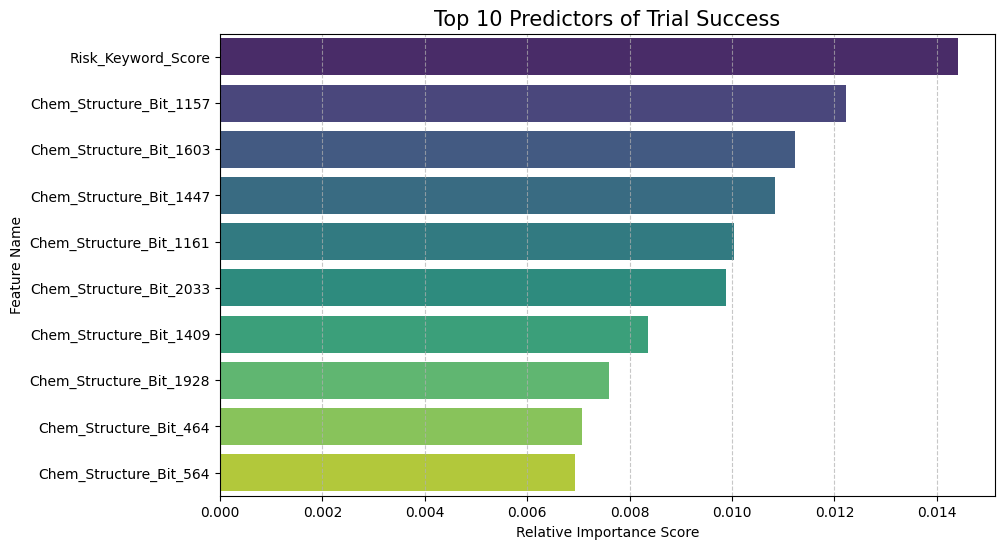


--- KEYWORD ANALYSIS ---
Importance of 'Risk Words' (tumor, metastatic, etc): 0.0144
Importance of 'Safe Words' (pain, healthy, etc):     0.0026


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- 6. FEATURE IMPORTANCE ANALYSIS ---")

# 1. Create Feature Names Map
# We have 2048 chemical bits, followed by our 3 text features
feature_names = [f"Chem_Structure_Bit_{i}" for i in range(2048)]
feature_names.extend(["Protocol_Length", "Risk_Keyword_Score", "Safe_Keyword_Score"])

# 2. Extract Importances
importances = model.feature_importances_
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort and Take Top 10
top_features = feat_df.sort_values(by='Importance', ascending=False).head(10)

# 4. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Predictors of Trial Success', fontsize=15)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 5. Text Analysis Verification
print("\n--- KEYWORD ANALYSIS ---")
risk_imp = feat_df[feat_df['Feature'] == 'Risk_Keyword_Score']['Importance'].values[0]
safe_imp = feat_df[feat_df['Feature'] == 'Safe_Keyword_Score']['Importance'].values[0]
print(f"Importance of 'Risk Words' (tumor, metastatic, etc): {risk_imp:.4f}")
print(f"Importance of 'Safe Words' (pain, healthy, etc):     {safe_imp:.4f}")